## 1. Import libraries and datasets.

In [ ]:
!wget https://huawei-ai-certification.obs.cn-north-4.myhuaweicloud.com/ENG/HCIP-AI%20EI%20Developer/V2.1/spa-eng.zip

In [ ]:
!unzip '/content/spa-eng.zip'

In [ ]:
import re
import io
import os
import time
import unicodedata

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

In [ ]:
PATH_TO_FILE = '/content/spa-eng/spa.txt'

## 2. Preprocessing steps.

**The preprocessing steps include:**
- Converting unicode to ascii
- Replacing particular characters with space
- Add a start and end token to the sentence.

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    #Create space between a word and the punctuation following it.
    #e.g: he is a boy. => he is a boy .
    w = re.sub(r"([?.!,¿])",r" \1 ",w)
    w = re.sub(r'[" "]+'," ",w)
    
    #Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+"," ", w)
    w = w.strip()
    
    #Add a start and an end token to the sentence so that the model knows when to stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
EN_SENTENCE = u'May I borrow this book?'
SP_SENTENCE = u'¿Puedo tomar prestado este libro?'

print(preprocess_sentence(EN_SENTENCE))
print(preprocess_sentence(SP_SENTENCE).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


- Remove the accents.
- Clean the sentences.
- Return word pairs in the format [ENGLISH, SPANISH]

In [ ]:
def create_dataset(PATH, NUM_EXAMPLES):
    LINES = io.open(PATH, encoding = 'UTF-8').read().strip().split('\n')
    
    WORD_PAIRS = [[preprocess_sentence(w) for w in l.split('\t')] for l in LINES[:NUM_EXAMPLES]]
    
    return zip(*WORD_PAIRS)

In [ ]:
EN, SP = create_dataset(PATH_TO_FILE, None)
print(EN[-1])
print('\n', SP[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>

 <start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def tokenize(LANG):
    LANG_TOKENIZER = tf.keras.preprocessing.text.Tokenizer(filters = '', oov_token = '<OOV>')
    LANG_TOKENIZER.fit_on_texts(LANG)
    
    TENSOR = LANG_TOKENIZER.texts_to_sequences(LANG)
    TENSOR = tf.keras.preprocessing.sequence.pad_sequences(TENSOR, padding = 'post')
    
    return TENSOR, LANG_TOKENIZER

def load_dataset(PATH, NUM_EXAMPLES = None):
    #Creating cleaned input, output pairs.
    TARG_LANG, INP_LANG = create_dataset(PATH, NUM_EXAMPLES)
    
    INPUT_TENSOR, INP_LANG_TOKENIZER = tokenize(INP_LANG)
    TARGET_TENSOR, TARG_LANG_TOKENIZER = tokenize(TARG_LANG)
    
    return INPUT_TENSOR, TARGET_TENSOR, INP_LANG_TOKENIZER, TARG_LANG_TOKENIZER

In [ ]:
NUM_EXAMPLES = 30000
INPUT_TENSOR, TARGET_TENSOR, INP_LANG, TARG_LANG = load_dataset(PATH_TO_FILE, NUM_EXAMPLES)

#Calculate maximum length of the target tensors.
MAX_LENGTH_TARG, MAX_LENGTH_INP = TARGET_TENSOR.shape[1], INPUT_TENSOR.shape[1]

#Creating training and validation sets
INPUT_TENSOR_TRAIN, INPUT_TENSOR_TEST, TARGET_TENSOR_TRAIN, TARGET_TENSOR_TEST = train_test_split(INPUT_TENSOR, TARGET_TENSOR, test_size = 0.2)

print(f'Length of input tensor train is: {len(INPUT_TENSOR_TRAIN)}')
print(f'Length of target tensor train is; {len(TARGET_TENSOR_TRAIN)}')
print(f'Length of input tensor test is: {len(INPUT_TENSOR_TEST)}')
print(f'Length of target tensor test is; {len(TARGET_TENSOR_TEST)}')

Length of input tensor train is: 24000
Length of target tensor train is; 24000
Length of input tensor test is: 6000
Length of target tensor test is; 6000


In [ ]:
#Convert text to index for word mapping.
def convert(LANG, TENSOR):
    for t in TENSOR:
        if t != 0:
            print('%d ----> %s' %(t, LANG.index_word[t]))
            
print('Input language ---> index to word mapping')
convert(INP_LANG, INPUT_TENSOR_TRAIN[0])
print()
print('Target language ---> index to word mapping')
convert(TARG_LANG, TARGET_TENSOR_TRAIN[0])

Input language ---> index to word mapping
2 ----> <start>
325 ----> pueden
1880 ----> conversar
35 ----> aqui
4 ----> .
3 ----> <end>

Target language ---> index to word mapping
2 ----> <start>
7 ----> you
26 ----> can
150 ----> talk
40 ----> here
4 ----> .
3 ----> <end>


In [ ]:
#Convert the file to a tf.data.Dataset object.
BUFFER_SIZE = len(INPUT_TENSOR_TRAIN)
BATCH_SIZE = 64
steps_per_epoch = len(INPUT_TENSOR_TRAIN) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(INP_LANG.word_index) + 1
vocab_tar_size = len(TARG_LANG.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((INPUT_TENSOR_TRAIN, TARGET_TENSOR_TRAIN)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 3. Build model.

In [ ]:
#Defining an encoder.
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
            return_sequences = True,
            return_state = True,
            recurrent_initializer = 'glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

#Sample input.
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print(f'Encoder output shape is: (batch size, units) {sample_output.shape}')
print(f'Encoder hidden state shape (batch size, units) {sample_hidden.shape}')

Encoder output shape is: (batch size, units) (64, 16, 1024)
Encoder hidden state shape (batch size, units) (64, 1024)


### Attention layer.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        
        #Attention weights shape.
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        #Context vector shape after sum == (batch_size, hidden_state)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print(f'Attention result shape (batch size, units) {attention_result.shape}')
print(f'Atention weights shape (batch size, sequence_length, 1) {attention_weights.shape}')

Attention result shape (batch size, units) (64, 1024)
Atention weights shape (batch size, sequence_length, 1) (64, 16, 1)


### Decoder network.

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences = True,
                                       return_state = True,
                                       recurrent_initializer = 'glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        #Used for attention.
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
print(f'Decoder output shape: (batch_size, vocab_size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab_size) (64, 4936)


### Optimizers and loss functions.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([TARG_LANG.word_index['<start>']] * BATCH_SIZE, 1)
        
        #Teacher forcing -> feeding the target as the next input.
        for t in range(1, targ.shape[1]):
            #Passing enc_output to the encoder.
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
            #Using teacher forcing.
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for(batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print(f'Epoch: {epoch + 1}, Batch: {batch}, Loss: {batch_loss.numpy()}')
            
    #Saving (checkpoint) the model every 2 epochs.
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Epoch: {} Loss: {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))

Epoch: 1, Batch: 0, Loss: 4.553936958312988
Epoch: 1, Batch: 100, Loss: 2.164884567260742
Epoch: 1, Batch: 200, Loss: 1.8792468309402466
Epoch: 1, Batch: 300, Loss: 1.7618895769119263
Epoch: 1 Loss: 2.0278
Epoch: 2, Batch: 0, Loss: 1.5501527786254883
Epoch: 2, Batch: 100, Loss: 1.4358311891555786
Epoch: 2, Batch: 200, Loss: 1.2896782159805298
Epoch: 2, Batch: 300, Loss: 1.3435341119766235
Epoch: 2 Loss: 1.3756
Epoch: 3, Batch: 0, Loss: 1.019819736480713
Epoch: 3, Batch: 100, Loss: 0.8766970634460449
Epoch: 3, Batch: 200, Loss: 0.9593451619148254
Epoch: 3, Batch: 300, Loss: 0.9142079949378967
Epoch: 3 Loss: 0.9586
Epoch: 4, Batch: 0, Loss: 0.6596505641937256
Epoch: 4, Batch: 100, Loss: 0.6937504410743713
Epoch: 4, Batch: 200, Loss: 0.7089295387268066
Epoch: 4, Batch: 300, Loss: 0.6111108064651489
Epoch: 4 Loss: 0.6447
Epoch: 5, Batch: 0, Loss: 0.45744389295578003
Epoch: 5, Batch: 100, Loss: 0.4276030361652374
Epoch: 5, Batch: 200, Loss: 0.39656752347946167
Epoch: 5, Batch: 300, Loss: 0.

## Defining test and visualisation functions.

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((MAX_LENGTH_TARG, MAX_LENGTH_INP))
  sentence = preprocess_sentence(sentence)
  
  inputs = []

  for i in sentence.split(' '):
    try:
      i_word_index = INP_LANG.word_index[i]
      inputs.append(i_word_index)
    except KeyError:
      continue

  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen = MAX_LENGTH_INP,
                                                         padding = 'post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([TARG_LANG.word_index['<start>']], 0)

  for t in range(MAX_LENGTH_TARG):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    #Storing the attentioon weights to plot later on.
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += TARG_LANG.index_word[predicted_id] + ' '

    if TARG_LANG.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    #The predicted ID is fed back into the model.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

#Function for plotting the attention weights.
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap = 'viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
#Load a model
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui <end>
Predicted translation: it s very cold here . <end> 


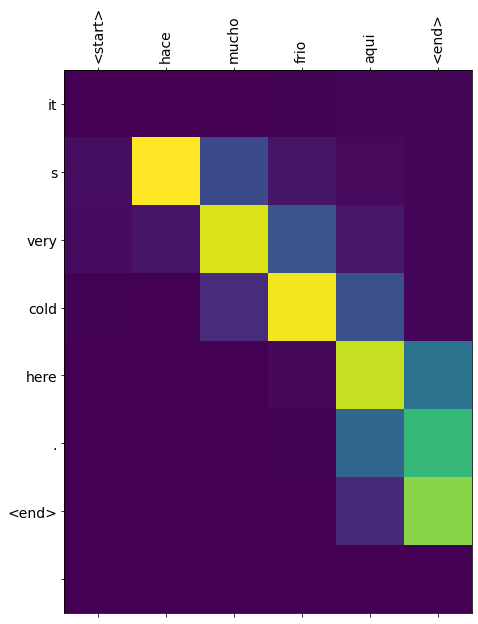

In [ ]:
translate(u'hace mucho frio aqui')

Input: <start> soy una gran fan de las computadoras <end>
Predicted translation: i m a big problem . <end> 


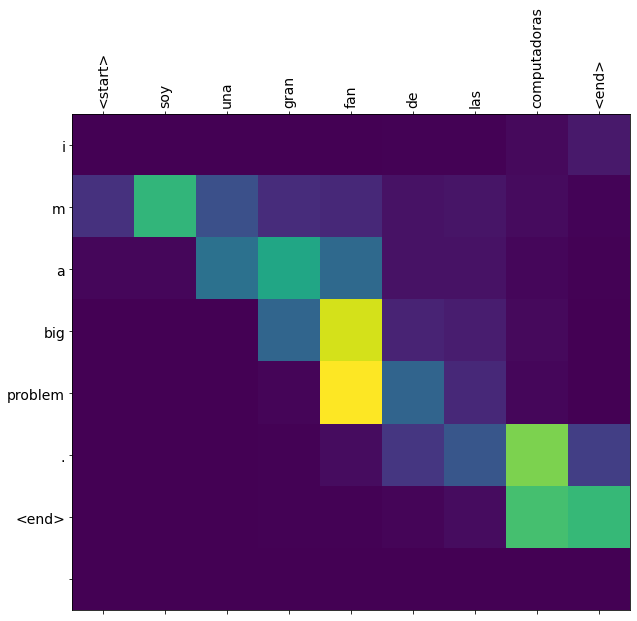

In [ ]:
translate(u'Soy una gran fan de las computadoras')

Input: <start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo <end>
Predicted translation: you do so much . <end> 


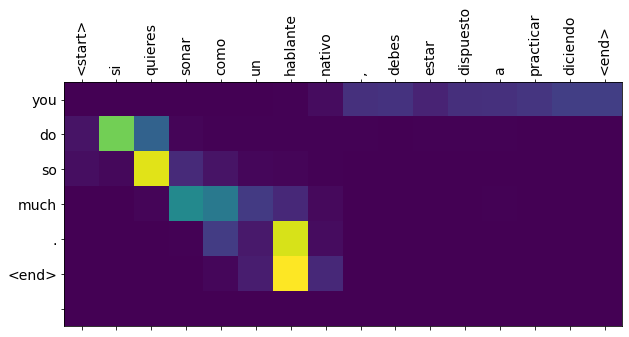

In [ ]:
translate(u'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo')